# Mie code

## Finding the scattering cross-section for a sphere using Mie coefficients

## 1) Dielectric particle

In [7]:
from scipy.special import riccati_jn, riccati_yn
import numpy as np
import matplotlib.pyplot as plt

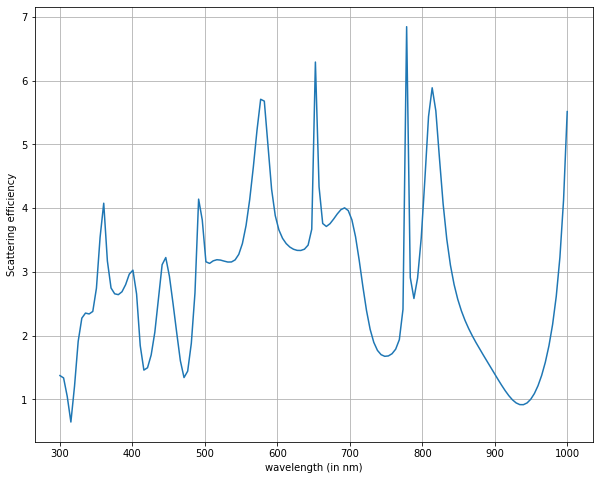

In [18]:
def riccati_1(o,y):
    n1,n1p = riccati_jn(o,y)
    return n1[o],n1p[o]

def riccati_2(o,y):
    n2,n2p = riccati_jn(o,y) 
    n3,n3p = riccati_yn(o,y)
    n4 = n2[o]+1j*n3[o]
    n4p = n2p[o]+1j*n3p[o]
    return n4,n4p


N1 = 3.5 #refractive index of particle
N = 1   #refractive index of medium
m = N1/N   #relative refractive index

a = 200e-9  #radius of the particle/scatterer
wvl_max = 1000e-9
wvl_min = 300e-9
step = 5e-9 #inteval of 0.5nm
num = (wvl_max-wvl_min)/step
num = round(num) 
wavelength = np.linspace(wvl_min,wvl_max,num)  

max_order = 4
a_n = np.zeros((num,max_order),dtype=np.complex)
b_n = np.zeros((num,max_order),dtype=np.complex)
a_n_amp = np.zeros((num,max_order))
b_n_amp = np.zeros((num,max_order))

#wvl = 500e-9
for n in range(0,max_order): 
#n = max_order
    for j in range(0,num):
        x = (2*np.pi*N*a)/wavelength[j]
        #we define 6 constants to make the final expressions simpler
        c1,c2= riccati_1(n,m*x)
        c3,c4= riccati_1(n,x)
        c5,c6 = riccati_2(n,x)

        #evaluate the final Mie coeffients a_n and b_n
        a_n[j,n] = (m*c1*c4 - c3*c2)/(m*c1*c6 - c5*c2)
        b_n[j,n] = (c1*c4 - m*c3*c2)/(c1*c6 - m*c5*c2)

        a_n_amp[j,n] = abs(a_n[j,n])
        b_n_amp[j,n] = abs(b_n[j,n])

#scattering cross section
Qsc = np.zeros(num) #scattering cross section
Qsc2 = np.zeros(num) #scattering efficiency (normalised cross section)
k = np.ones(num)
G = np.pi*a*a #geometrical cross section
for j in range(num):
    Qsc[j] = 0
    k[j] = 2*np.pi/wavelength[j]
    for n in range(max_order):
        Qsc[j] = Qsc[j] + ((2*n)+1)*(a_n_amp[j,n]**2 +b_n_amp[j,n]**2)
    Qsc[j] = Qsc[j]*(2*np.pi/(k[j])**2)
    Qsc2[j] = Qsc[j]/G

plt.figure(figsize=(10,8))
plt.plot(wavelength*1e9,Qsc2)
plt.xticks(np.arange(300,1100,100))
plt.xlabel('wavelength (in nm)')
plt.ylabel('Scattering efficiency')
plt.grid(True)

### The above figure shows a plot of the Scattering efficiency as a function of wavelength for a spherical dielectric paricle of  radius 200nm. The refractive index of the particle is 3.5 and that of the medium is 1.

----------------------------------------------------------------------------------------------------------------------

## 2) Metal particle

### Defining the material (Ag) 
Drude-Lorentz model (Rakic et al. 1998)

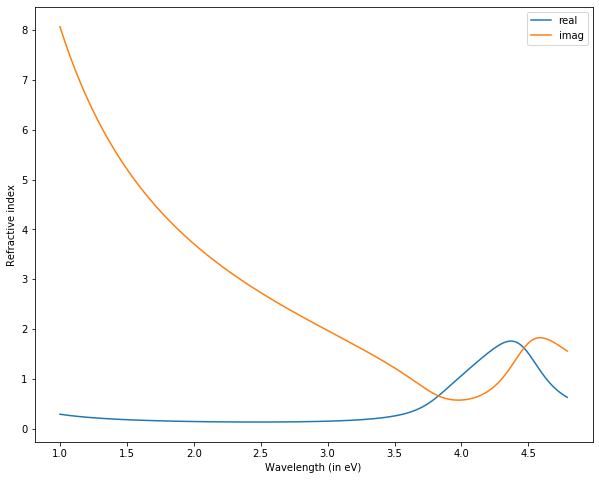

In [19]:
wp = 9.01 #in eV
omega_p_squared = (8.28**2) #in eV
f = [0.845, 0.065, 0.124, 0.011, 0.840, 5.646] #freq 
gamma = [0.048, 3.886, 0.452, 0.065, 0.916, 2.419] #width of plasmon resonance in eV
w_param = [0,0.816, 4.481, 8.185, 9.083, 20.29] #in eV (added zero as first value so array indices are preserved)

#new freq range from meep library
w_min = 1 #in eV
w_max = 4.8  #in eV
dw = 0.01
n = (w_max-w_min)/dw
n = round(n)

ep_final_r = []
ep_final_i = []

for w in np.arange(w_min,w_max,dw):
    #Drude term
    ep_d_r = 1 - (omega_p_squared/(w**2+gamma[0]**2))
    ep_d_i = (w*omega_p_squared*gamma[0])/(w*w*(w**2 + gamma[0]**2))
    #Lorentz term
    ep_l_r = 0
    ep_l_i = 0
    for j in range(1,6,1):
        ep_l_r = ep_l_r + (f[j]*wp*wp*(w_param[j]**2-w**2))/((w_param[j]**2-w**2)**2+(w*gamma[j])**2)
        ep_l_i = ep_l_i + (f[j]*wp*wp*w*gamma[j])/((w_param[j]**2-w**2)**2+(w*gamma[j])**2)
    ep_final_r.append(ep_d_r + ep_l_r)
    ep_final_i.append(ep_d_i + ep_l_i)

eps = np.ones(n,dtype=np.complex)
N = np.ones(n,dtype=np.complex)
for j in range(0,n):
    eps[j] = ep_final_r[j] + (1j*ep_final_i[j])
    N[j] = np.sqrt(eps[j])

i2 = np.arange(w_min,w_max,dw)
plt.figure(figsize=(10,8))
plt.plot(i2,N.real,label='real')
plt.plot(i2,N.imag,label='imag')
plt.xlabel('Wavelength (in eV)')
plt.ylabel('Refractive index')
plt.legend()

C:\Users\Desmond Quinn\anaconda3\lib\site-packages\scipy\special\_basic.py:754: ComplexWarning: Casting complex values to real discards the imaginary part
  nm, jn, jnp = specfun.rctj(n1, x)
C:\Users\Desmond Quinn\anaconda3\lib\site-packages\scipy\special\_basic.py:806: ComplexWarning: Casting complex values to real discards the imaginary part
  nm, jn, jnp = specfun.rcty(n1, x)


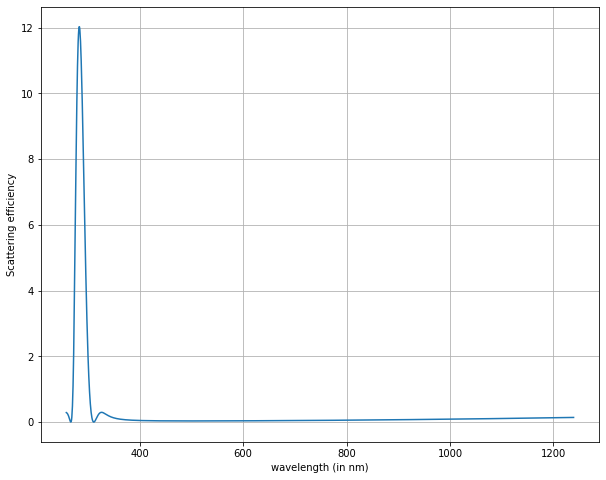

In [21]:
a = 10e-9 #radius of the particle/scatterer 
wvl_max = 4.8 #in eV
wvl_min = 1   #in eV
step = 0.01 #interval of 0.01eV
num = (wvl_max-wvl_min)/step
num = round(num) 
wavelength = np.linspace(wvl_min,wvl_max,num)  #for plotting

max_order = 4
a_n = np.zeros((num,max_order),dtype=np.complex)
b_n = np.zeros((num,max_order),dtype=np.complex)
a_n_amp = np.zeros((num,max_order))
b_n_amp = np.zeros((num,max_order))

Nm = 1

#to convert eV to m
h = 4.13e-15 #Planck constant in eV
c = 3e8  #speed of light in ms-1
wavelength2 = np.ones(num)
wavelength2 = h*c/wavelength

for n in range(0,max_order): 
    for j in range(0,num):
        N[j] = N[j].real
        m = N[j]/Nm
        x = (2*np.pi*N[j]*a)/wavelength2[j]
        #we define 6 constants to make the final expressions simpler
        c1,c2= riccati_1(n,m*x)
        c3,c4= riccati_1(n,x)
        c5,c6 = riccati_2(n,x)

        #evaluate the final Mie coeffients a_n and b_n
        a_n[j,n] = (m*c1*c4 - c3*c2)/(m*c1*c6 - c5*c2)
        b_n[j,n] = (c1*c4 - m*c3*c2)/(c1*c6 - m*c5*c2)

        a_n_amp[j,n] = abs(a_n[j,n])
        b_n_amp[j,n] = abs(b_n[j,n])
    

#scattering cross section
Qsc = np.zeros(num) #scattering cross section
Qsc2 = np.zeros(num) #scattering efficiency (normalised cross section)
k = np.ones(num)
G = np.pi*a*a #geometrical cross section
for j in range(num):
    Qsc[j] = 0
    k[j] = 2*np.pi/wavelength2[j]
    for n in range(max_order):
        Qsc[j] = Qsc[j] + ((2*n)+1)*(a_n_amp[j,n]**2 +b_n_amp[j,n]**2)
    Qsc[j] = Qsc[j]*(2*np.pi/(k[j])**2)
    Qsc2[j] = Qsc[j]/G

plt.figure(figsize=(10,8))
plt.plot(wavelength2*1e9,Qsc2)
plt.xlabel('wavelength (in nm)')
plt.ylabel('Scattering efficiency')
plt.grid(True) 

### The above figure shows a plot of the Scattering function as a function of wavelength for a spherical metal (Ag) particle of  radius 10nm. 